In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statannotations.Annotator import Annotator
import scipy

#style for figures
color_palette = sns.color_palette("colorblind")
sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")

#styles for error and markers in sns.lineplot

thin_custom_lw = 1.2
custom_lw = thin_custom_lw/0.65

filled_marker_style = dict(marker='o',  markersize=5,
                           color='k',
                           markerfacecolor='w',
                           markeredgecolor='k',
                          markeredgewidth=thin_custom_lw)

filled_marker_style_white = dict(marker='o',  markersize=5,
                           color='w',
                           markerfacecolor='w',
                           markeredgecolor='w',
                          markeredgewidth=custom_lw)
######################

error_style_white = {"capsize": 4.4, 
                "ecolor": "w",
               "barsabove":False, 
               "elinewidth":custom_lw, 
               "capthick":custom_lw,
                    "zorder": 8}

error_style = {"capsize": 4, 
                "ecolor": "k",
                "barsabove":False, 
                "elinewidth":thin_custom_lw, 
                "capthick":thin_custom_lw,
                "zorder": 9}

# number of iterations and seed for bootstrapping during calculation of confidence intervals
n_boot = 10000
seed = 10

In [2]:
def calculate_ci (df, var, group, ci=0.95, rnd=3): #dataframe, list of variables, confidence interval, decimals for roundng
    genotypes = df[group].unique()
    ci_df = pd.DataFrame()

    for v in var:
        ci_lower = pd.Series(dtype="float64", name=f"{v}_ci_lower")
        ci_upper = pd.Series(dtype="float64", name=f"{v}_ci_upper")
        for g in genotypes:
            vals = df[(df[group]==g)][v].values
            vals = [item for item in vals if not(pd.isna(item)) == True]
            res = scipy.stats.bootstrap((vals,),
                                        np.mean,
                                        confidence_level=ci,
                                        n_resamples=int(n_boot),
                                        random_state=int(seed),
                                       method="percentile")
            ci_l, ci_u = res.confidence_interval
            ci_lower = pd.concat((ci_lower,pd.Series(data=ci_l, index=[g], name=f"ci_lower")))
            ci_upper = pd.concat((ci_upper,pd.Series(data=ci_u, index=[g], name=f"ci_upper")))

        ci_lower.name = "ci_lower"
        ci_upper.name = "ci_upper"
        ci_temp = pd.concat((ci_lower,ci_upper), axis=1)
        ci_temp.index.name=group
        ci_temp["parameter"] = v
        ci_temp.set_index('parameter', append=True, inplace=True)

        df_var = df.groupby([group]).mean()[v]

        arr = [df_var.index.values, [df_var.name]*len(genotypes)]
        tuples = list(zip(*arr))
        multi_idx = pd.MultiIndex.from_tuples(tuples, names=[group, "parameter"])

        df_var.index = multi_idx

        df_var.name = "mean"

        df_temp = pd.concat((df_var, ci_temp), axis=1)
        ci_df = pd.concat((ci_df,df_temp), axis=0)
    return ci_df.round(rnd) 

In [3]:
data = pd.read_csv("ttap2_rel_activity_freq.csv", index_col=0)
data_per_slice = pd.read_csv("ttap2_rel_activity_freq_per_slice.csv", index_col=0)
data_active_cells = pd.read_csv("ttap2_active_cells_per_slice.csv", index_col=0)

In [4]:
data["freq_stat"] = "y"
data.loc[np.isnan(data["intraburst_freq"]), "freq_stat"] = "n"

# relative activity under 15 µM TTA-P2

C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3539761070.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "KO"])
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\185011531.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df.groupby([group]).mean()[v]


                          mean  ci_lower  ci_upper
genotype_2 parameter                              
KO         rel_activity  0.995     0.851     1.164
wt         rel_activity  0.569     0.341     0.823


C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 46.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


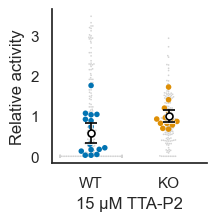

In [6]:
y = "rel_activity"
data_subset = data[(data["pos"]==2)&
                   (data["control"]!="y")].dropna(subset=[y]) 

df = data_per_slice[(data_per_slice["pos"]==2)&
                    (data_per_slice["control"]!="y")].dropna(subset=[y])

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_2", y=y, data=df,
               hue_order= ["wt", "KO"], 
                hue="genotype_2",
                palette=[color_palette[0], color_palette[1]],
                 s=4,
                zorder=2, legend=False)

g = sns.swarmplot(x="genotype_2", y=y, data=data_subset,
               hue_order= ["wt", "KO"], 
                  size=1.2,
            hue="genotype_2",
                  zorder=1,  palette=["lightgrey", "lightgrey"])

####################################

sns.lineplot(x="genotype_2", y=y, data=df, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype_2", y=y, data=df, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.legend([],[], frameon=False)
g.set_xticklabels(["WT", "KO"])
g.set_xlim([-0.5,1.5])

g.set_ylabel("Relative activity")
g.set_xlabel("15 µM TTA-P2")

print(calculate_ci(df, [y], "genotype_2"))

C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 52.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\1399738681.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "WT ctrl", "KO", "KO ctrl"])
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\185011531.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df.groupb

                       mean  ci_lower  ci_upper
genotype_2 parameter                           
KO         activity   0.871     0.745     1.018
KO_ctrl    activity   0.875     0.662     1.096
wt         activity   0.256     0.153     0.370
wt_ctrl    activity   0.449     0.348     0.597


C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dinhha\AppData\Local\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


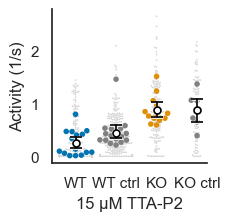

In [7]:
y = "activity"
data_subset = data[(data["pos"]==2)].dropna(subset=[y]) 

df = data_per_slice[(data_per_slice["pos"]==2)].dropna(subset=[y])

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_2", y=y, data=df,
               hue_order= ["wt", "wt_ctrl", "KO", "KO_ctrl"], 
                hue="genotype_2",
                palette=[color_palette[0], "grey", color_palette[1], "grey"],
                 s=4,
                zorder=2, legend=False)

g = sns.swarmplot(x="genotype_2", y=y, data=data_subset,
               hue_order= ["wt", "wt_ctrl", "KO", "KO_ctrl"], 
                  size=1.2,
            hue="genotype_2",
                  zorder=1,  palette=["lightgrey", "lightgrey", "lightgrey", "lightgrey"])

####################################

sns.lineplot(x="genotype_2", y=y, data=df, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype_2", y=y, data=df, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.legend([],[], frameon=False)
g.set_xticklabels(["WT", "WT ctrl", "KO", "KO ctrl"])

g.set_ylabel("Activity (1/s)")
g.set_xlabel("15 µM TTA-P2") 

print(calculate_ci(df, [y], "genotype_2"))

# relative intra-burst freq under 15 µM TTA-P2


                                 mean  ci_lower  ci_upper
genotype_2 parameter                                     
KO         rel_intraburst_freq  0.913     0.837     0.995
wt         rel_intraburst_freq  1.182     1.101     1.265


C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\2749229896.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "KO"])
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\185011531.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df.groupby([group]).mean()[v]


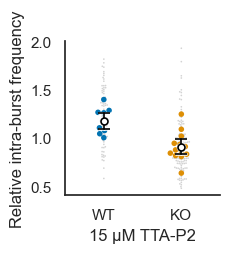

In [8]:
y = "rel_intraburst_freq"
data_subset = data[(data["pos"]==2)&
                   (data["control"]!="y")&
                (data["count"]>5)].dropna(subset=[y])

df = data_per_slice[(data_per_slice["pos"]==2)&
                    (data_per_slice["control"]!="y")&
                    (data_per_slice["count"]>5)].dropna(subset=[y])

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_2", y=y, data=df,
               hue_order= ["wt", "KO"], 
                hue="genotype_2",
                palette=[color_palette[0], color_palette[1]],
                 s=4,
                zorder=2, legend=False)

g = sns.swarmplot(x="genotype_2", y=y, data=data_subset,
               hue_order= ["wt", "KO"], 
                  size=1.2,
            hue="genotype_2",
                  zorder=1,  palette=["lightgrey", "lightgrey"])

####################################

sns.lineplot(x="genotype_2", y=y, data=df, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype_2", y=y, data=df, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.legend([],[], frameon=False)
g.set_xticklabels(["WT", "KO"])
#g.set_yticks([0,0.5,1,1.5,2,2.5])
#g.set_ylim([0,3.2])
g.set_xlim([-0.5,1.5])

g.set_ylabel("Relative intra-burst frequency")
g.set_xlabel("15 µM TTA-P2")

plt.legend([],[], frameon=False)

print(calculate_ci(df, [y], "genotype_2"))

C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3641401254.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "Wt ctrl", "KO", "KO ctrl"])
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\185011531.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df.groupby([group]).mean()[v]


                             mean  ci_lower  ci_upper
genotype_2 parameter                                 
KO         intraburst_freq  1.239     1.136     1.351
KO_ctrl    intraburst_freq  1.307     1.162     1.459
wt         intraburst_freq  0.972     0.906     1.041
wt_ctrl    intraburst_freq  0.851     0.747     1.003


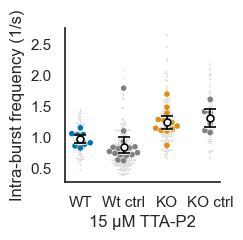

In [9]:
y = "intraburst_freq"
data_subset = data[(data["pos"]==2)&
                (data["count"]>5)].dropna(subset=[y])

df = data_per_slice[(data_per_slice["pos"]==2)&
                    (data_per_slice["count"]>5)].dropna(subset=[y])

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_2", y=y, data=df,
               hue_order= ["wt", "wt_ctrl", "KO", "KO_ctrl"], 
                hue="genotype_2",
                palette=[color_palette[0],"grey", color_palette[1], "grey"],
                 s=4, zorder=2, legend=False)

g = sns.swarmplot(x="genotype_2", y=y, data=data_subset,
               hue_order= ["wt", "wt_ctrl", "KO", "KO_ctrl"], 
                  size=1.2,
            hue="genotype",
                  zorder=1,  palette=["lightgrey", "lightgrey", "lightgrey", "lightgrey"])

####################################

sns.lineplot(x="genotype_2", y=y, data=df, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype_2", y=y, data=df, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.legend([],[], frameon=False)
g.set_xticklabels(["WT", "Wt ctrl", "KO", "KO ctrl"])

g.set_ylabel("Intra-burst frequency (1/s)")
g.set_xlabel("15 µM TTA-P2")

plt.legend([],[], frameon=False)

print(calculate_ci(df, [y], "genotype_2"))

                                        mean  ci_lower  ci_upper
genotype_2 parameter                                            
KO         n_percentage_active_cells  90.288    84.286    95.110
KO_ctrl    n_percentage_active_cells  83.588    73.129    93.793
wt         n_percentage_active_cells  34.371    22.233    47.316
wt_ctrl    n_percentage_active_cells  75.494    68.198    82.513


C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3327031123.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "WT ctrl","KO","KO ctrl"])
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\185011531.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df.groupby([group]).mean()[v]


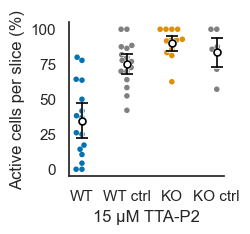

In [11]:
y = "n_percentage_active_cells"

data_subset = data_active_cells


fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_2", y=y, 
                data=data_subset,
                hue_order = ["wt", "wt_ctrl", "KO", "KO_ctrl"],
                order = ["wt", "wt_ctrl", "KO", "KO_ctrl"],
                hue="genotype_2",
                palette=[color_palette[0],"grey", color_palette[1], "grey"],
                size=4,
                zorder=1)

##### plot white markers
sns.lineplot(x="genotype_2", y=y,
             data=data_subset,
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

#plot black markers
sns.lineplot(x="genotype_2", y=y, 
             data=data_subset,
            lw=0,
            errorbar=("ci",95),
            n_boot=n_boot, seed=seed,
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)


g.set_ylabel("Active cells per slice (%)")
g.set_xlabel("") 
g.set_xticklabels(["WT", "WT ctrl","KO","KO ctrl"])
g.set_xlabel("15 µM TTA-P2")

plt.legend([],[], frameon=False)



g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

print(calculate_ci(data_subset, [y], "genotype_2"))

# only WT cells analyzed with existing intra-burst freq at 15 µM TTA-P2

C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\470334716.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_4 = data_subset_4.groupby(["genotype_2", "recording", "pos"]).mean().reset_index()
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\470334716.py:21: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(x="pos", y="rel_freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\470334716.py:27: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(x="pos", y="rel_freq", data=data_subset_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\470334716.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["0 µM", "15 µM"])


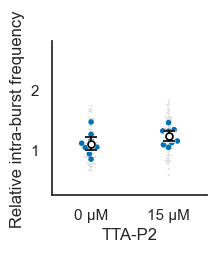

                mean  ci_lower  ci_upper
pos parameter                           
1   rel_freq   1.100     0.995     1.219
2   rel_freq   1.225     1.141     1.311


C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\185011531.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df.groupby([group]).mean()[v]


In [12]:
# cells at 15µM TTA-P2 with intra burst freq
data_subset = data[(data["pos"]==2)&
                   (data["control"]!="y")&
                (data["count"]>5)].dropna(subset=["rel_intraburst_freq"])
# data_subset_2 are cells from data_subset at pos 1
data_subset_2 = data_subset[["cell", "recording","rel_freq_pos1", "genotype_2", ]].rename(columns={"rel_freq_pos1": "rel_freq"})
data_subset_2["pos"] = 1
#reshape data_subset to data_subset_3
data_subset_3 = data_subset[["cell", "recording","rel_intraburst_freq", "genotype_2"]].rename(columns={"rel_intraburst_freq": "rel_freq"})
data_subset_3["pos"] = 2
#concat data
data_subset_4 = pd.concat((data_subset_2, data_subset_3)).reset_index(drop=True)
data_subset_4 = data_subset_4.query("genotype_2=='wt'")

df_4 = data_subset_4.groupby(["genotype_2", "recording", "pos"]).mean().reset_index()
df_4["pos_mod"] = df_4["pos"]-1


fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="pos", y="rel_freq", data=df_4,
               order= [1, 2], 
                palette=[color_palette[0], color_palette[0]],
                 s=4,
                zorder=2)

g = sns.swarmplot(x="pos", y="rel_freq", data=data_subset_4, 
               order= [1, 2], 
                  size=1.2,
                  zorder=1,  palette=["lightgrey", "lightgrey"])




##### plot white markers
sns.lineplot(x="pos_mod", y="rel_freq",
             data=df_4,
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

#plot black markers
sns.lineplot(x="pos_mod", y="rel_freq", 
             data=df_4,
            lw=0,
            errorbar=("ci",95),
            n_boot=n_boot, seed=seed,
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)




plt.legend([],[], frameon=False)


g.set_ylabel("Relative intra-burst frequency")
g.set_xlabel("") 
g.set_xticklabels(["0 µM", "15 µM"])
g.set_xlabel("TTA-P2")

plt.xlim(-0.5, 1.5)
plt.ylim(0.25, 2.8)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.show()
print(calculate_ci(df_4, ["rel_freq"], "pos"))


C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3517428367.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_4 = data_subset_4.groupby(["genotype_3", "recording", "pos"]).mean().reset_index()
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3517428367.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(x="genotype_3", y="rel_freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3517428367.py:19: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.swarmplot(x="genotype_3", y="rel_freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3517428367.py:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.

                       mean  ci_lower  ci_upper
genotype_3 parameter                           
wt_1       rel_freq   1.100     0.995     1.219
wt_2       rel_freq   1.225     1.141     1.311
wt_ctrl_1  rel_freq   1.136     0.995     1.319
wt_ctrl_2  rel_freq   1.072     0.941     1.263


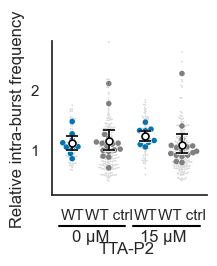

In [13]:
data_subset = data[(data["pos"]==2)&
                (data["count"]>5)].dropna(subset=["rel_intraburst_freq"])
# data_subset_2 are cells from data_subset at pos 1
data_subset_2 = data_subset[["cell", "recording","rel_freq_pos1", "genotype_2" ]].rename(columns={"rel_freq_pos1": "rel_freq"})
data_subset_2["pos"] = 1
#reshape data_subset to data_subset_3
data_subset_3 = data_subset[["cell", "recording","rel_intraburst_freq", "genotype_2"]].rename(columns={"rel_intraburst_freq": "rel_freq"})
data_subset_3["pos"] = 2
#concat data
data_subset_4 = pd.concat((data_subset_2, data_subset_3)).reset_index(drop=True)
data_subset_4 = data_subset_4[(data_subset_4["genotype_2"]=="wt") | (data_subset_4["genotype_2"]== "wt_ctrl")]
data_subset_4["genotype_3"] = data_subset_4["genotype_2"]+"_"+(data_subset_4["pos"]).astype(str)
df_4 = data_subset_4.groupby(["genotype_3", "recording", "pos"]).mean().reset_index()



fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_3", y="rel_freq", data=df_4, 
               order= ["wt_1", "wt_ctrl_1", "wt_2", "wt_ctrl_2"],
                palette=[color_palette[0], "grey"],
                 s=4,
                zorder=2)

g = sns.swarmplot(x="genotype_3", y="rel_freq", data=data_subset_4, 
               order= ["wt_1", "wt_ctrl_1", "wt_2", "wt_ctrl_2"],
                  size=1.2,
                  zorder=1,  palette=["lightgrey", "lightgrey"])




##### plot white markers
sns.lineplot(x="genotype_3", y="rel_freq",
             data=df_4,
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

#plot black markers
sns.lineplot(x="genotype_3", y="rel_freq", 
             data=df_4,
            lw=0,
            errorbar=("ci",95),
            n_boot=n_boot, seed=seed,
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)



plt.legend([],[], frameon=False)


g.set_ylabel("Relative intra-burst frequency")
g.set_xlabel("") 
g.set_xticklabels(["WT", "WT ctrl", "WT", "WT ctrl"])
#g.set_xlabel("TTA-P2")

plt.ylim(0.25, 2.8)


trans = g.get_xaxis_transform()
g.annotate('0 µM', xy=(0.5, -0.22), xycoords=trans, ha="center", va="top")
g.plot([-0.35,1.45],[-.2,-.2], color="k", transform=trans, clip_on=False)

g.annotate('15 µM', xy=(2.5, -0.22), xycoords=trans, ha="center", va="top")
g.plot([1.65,3.5],[-.2,-.2], color="k", transform=trans, clip_on=False)


g.annotate('TTA-P2', xy=(1.5, -0.3), xycoords=trans, ha="center", va="top")


g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

print(calculate_ci(df_4, ["rel_freq"], "genotype_3"))



C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\2248963675.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_4 = data_subset_4.groupby(["genotype_3", "recording", "pos"]).mean().reset_index()
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\2248963675.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(x="genotype_3", y="freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\2248963675.py:19: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.swarmplot(x="genotype_3", y="freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\2248963675.py:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplo

                       mean  ci_lower  ci_upper
genotype_3 parameter                           
wt_1       freq       0.929     0.840     1.029
wt_2       freq       0.972     0.906     1.041
wt_ctrl_1  freq       0.960     0.841     1.114
wt_ctrl_2  freq       0.851     0.747     1.003


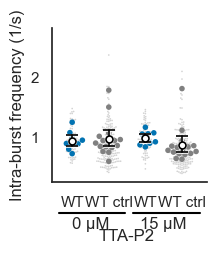

In [14]:
data_subset = data[(data["pos"]==2)&
                (data["count"]>5)].dropna(subset=["rel_intraburst_freq"])
# data_subset_2 are cells from data_subset at pos 1
data_subset_2 = data_subset[["cell", "recording","freq_pos1", "genotype_2" ]].rename(columns={"freq_pos1": "freq"})
data_subset_2["pos"] = 1
#reshape data_subset to data_subset_3
data_subset_3 = data_subset[["cell", "recording","intraburst_freq", "genotype_2"]].rename(columns={"intraburst_freq": "freq"})
data_subset_3["pos"] = 2
#concat data
data_subset_4 = pd.concat((data_subset_2, data_subset_3)).reset_index(drop=True)
data_subset_4 = data_subset_4[(data_subset_4["genotype_2"]=="wt") | (data_subset_4["genotype_2"]== "wt_ctrl")]
data_subset_4["genotype_3"] = data_subset_4["genotype_2"]+"_"+(data_subset_4["pos"]).astype(str)
df_4 = data_subset_4.groupby(["genotype_3", "recording", "pos"]).mean().reset_index()



fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_3", y="freq", data=df_4, 
               order= ["wt_1", "wt_ctrl_1", "wt_2", "wt_ctrl_2"],
                palette=[color_palette[0], "grey"],
                 s=4,
                zorder=2)

g = sns.swarmplot(x="genotype_3", y="freq", data=data_subset_4, 
               order= ["wt_1", "wt_ctrl_1", "wt_2", "wt_ctrl_2"],
                  size=1.2,
                  zorder=1,  palette=["lightgrey", "lightgrey"])




##### plot white markers
sns.lineplot(x="genotype_3", y="freq",
             data=df_4,
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

#plot black markers
sns.lineplot(x="genotype_3", y="freq", 
             data=df_4,
            lw=0,
            errorbar=("ci",95),
            n_boot=n_boot, seed=seed,
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)



plt.legend([],[], frameon=False)


g.set_ylabel("Intra-burst frequency (1/s)")
g.set_xlabel("") 
g.set_xticklabels(["WT", "WT ctrl", "WT", "WT ctrl"])
#g.set_xlabel("TTA-P2")



trans = g.get_xaxis_transform()
g.annotate('0 µM', xy=(0.5, -0.22), xycoords=trans, ha="center", va="top")
g.plot([-0.35,1.45],[-.2,-.2], color="k", transform=trans, clip_on=False)

g.annotate('15 µM', xy=(2.5, -0.22), xycoords=trans, ha="center", va="top")
g.plot([1.65,3.5],[-.2,-.2], color="k", transform=trans, clip_on=False)

g.annotate('TTA-P2', xy=(1.5, -0.3), xycoords=trans, ha="center", va="top")




plt.ylim(0.25, 2.8)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)


data_subset_4.to_csv("ttap2_freq_WT_pos2_positive.csv")
print(calculate_ci(df_4, ["freq"], "genotype_3"))


# only KO cells analyzed with existing intra-burst freq at 15 µM TTA-P2

C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\4112423219.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_4 = data_subset_4.groupby(["genotype_2", "recording", "pos"]).mean().reset_index()
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\4112423219.py:21: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(x="pos", y="rel_freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\4112423219.py:27: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(x="pos", y="rel_freq", data=data_subset_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\4112423219.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["0 µM", "15 µM"])
C:\Users\dinhha\AppData\Loca

                mean  ci_lower  ci_upper
pos parameter                           
1   rel_freq   0.924     0.846     1.021
2   rel_freq   0.905     0.830     0.987


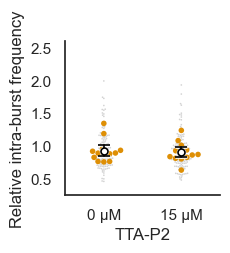

In [15]:
# cells at 15µM TTA-P2 with intra burst freq
data_subset = data[(data["pos"]==2)&
                   (data["control"]!="y")&
                (data["count"]>5)].dropna(subset=["rel_intraburst_freq"])
# data_subset_2 are cells from data_subset at pos 1
data_subset_2 = data_subset[["cell", "recording","rel_freq_pos1", "genotype_2", ]].rename(columns={"rel_freq_pos1": "rel_freq"})
data_subset_2["pos"] = 1
#reshape data_subset to data_subset_3
data_subset_3 = data_subset[["cell", "recording","rel_intraburst_freq", "genotype_2"]].rename(columns={"rel_intraburst_freq": "rel_freq"})
data_subset_3["pos"] = 2
#concat data
data_subset_4 = pd.concat((data_subset_2, data_subset_3)).reset_index(drop=True)
data_subset_4 = data_subset_4.query("genotype_2=='KO'")

df_4 = data_subset_4.groupby(["genotype_2", "recording", "pos"]).mean().reset_index()
df_4["pos_mod"] = df_4["pos"]-1


fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="pos", y="rel_freq", data=df_4,
               order= [1, 2], 
                palette=[color_palette[1], color_palette[1]],
                 s=4,
                zorder=2)

g = sns.swarmplot(x="pos", y="rel_freq", data=data_subset_4, 
               order= [1, 2], 
                  size=1.2,
                  zorder=1,  palette=["lightgrey", "lightgrey"])




##### plot white markers
sns.lineplot(x="pos_mod", y="rel_freq",
             data=df_4,
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

#plot black markers
sns.lineplot(x="pos_mod", y="rel_freq", 
             data=df_4,
            lw=0,
            errorbar=("ci",95),
            n_boot=n_boot, seed=seed,
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)




plt.legend([],[], frameon=False)


g.set_ylabel("Relative intra-burst frequency")
g.set_xlabel("") 
g.set_xticklabels(["0 µM", "15 µM"])
g.set_xlabel("TTA-P2")

plt.xlim(-0.5, 1.5)
plt.ylim(0.25, 2.6)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)


print(calculate_ci(df_4, ["rel_freq"], "pos"))


C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\748884766.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_4 = data_subset_4.groupby(["genotype_3", "recording", "pos"]).mean().reset_index()
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\748884766.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(x="genotype_3", y="rel_freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\748884766.py:19: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.swarmplot(x="genotype_3", y="rel_freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\748884766.py:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swar

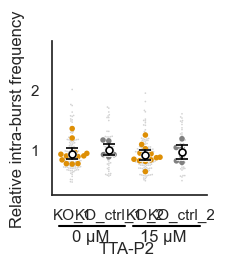

                       mean  ci_lower  ci_upper
genotype_3 parameter                           
KO_1       rel_freq   0.924     0.846     1.021
KO_2       rel_freq   0.905     0.830     0.987
KO_ctrl_1  rel_freq   0.997     0.913     1.084
KO_ctrl_2  rel_freq   0.954     0.849     1.066


C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\185011531.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df.groupby([group]).mean()[v]


In [16]:
data_subset = data[(data["pos"]==2)&
                (data["count"]>5)].dropna(subset=["rel_intraburst_freq"])
# data_subset_2 are cells from data_subset at pos 1
data_subset_2 = data_subset[["cell", "recording","rel_freq_pos1", "genotype_2" ]].rename(columns={"rel_freq_pos1": "rel_freq"})
data_subset_2["pos"] = 1
#reshape data_subset to data_subset_3
data_subset_3 = data_subset[["cell", "recording","rel_intraburst_freq", "genotype_2"]].rename(columns={"rel_intraburst_freq": "rel_freq"})
data_subset_3["pos"] = 2
#concat data
data_subset_4 = pd.concat((data_subset_2, data_subset_3)).reset_index(drop=True)
data_subset_4 = data_subset_4[(data_subset_4["genotype_2"]=="KO") | (data_subset_4["genotype_2"]== "KO_ctrl")]
data_subset_4["genotype_3"] = data_subset_4["genotype_2"]+"_"+(data_subset_4["pos"]).astype(str)
df_4 = data_subset_4.groupby(["genotype_3", "recording", "pos"]).mean().reset_index()



fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_3", y="rel_freq", data=df_4, 
               order= ["KO_1", "KO_ctrl_1", "KO_2", "KO_ctrl_2"],
                palette=[color_palette[1], "grey"],
                 s=4,
                zorder=2)

g = sns.swarmplot(x="genotype_3", y="rel_freq", data=data_subset_4, 
               order= ["KO_1", "KO_ctrl_1", "KO_2", "KO_ctrl_2"],
                  size=1.2,
                  zorder=1,  palette=["lightgrey", "lightgrey"])




##### plot white markers
sns.lineplot(x="genotype_3", y="rel_freq",
             data=df_4,
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

#plot black markers
sns.lineplot(x="genotype_3", y="rel_freq", 
             data=df_4,
            lw=0,
            errorbar=("ci",95),
            n_boot=n_boot, seed=seed,
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)



plt.legend([],[], frameon=False)


g.set_ylabel("Relative intra-burst frequency")
g.set_xlabel("") 
#g.set_xticklabels(["WT", "WT ctrl", "WT", "WT ctrl"])
#g.set_xlabel("TTA-P2")

plt.ylim(0.25, 2.8)


trans = g.get_xaxis_transform()
g.annotate('0 µM', xy=(0.5, -0.22), xycoords=trans, ha="center", va="top")
g.plot([-0.35,1.45],[-.2,-.2], color="k", transform=trans, clip_on=False)

g.annotate('15 µM', xy=(2.5, -0.22), xycoords=trans, ha="center", va="top")
g.plot([1.65,3.5],[-.2,-.2], color="k", transform=trans, clip_on=False)


g.annotate('TTA-P2', xy=(1.5, -0.3), xycoords=trans, ha="center", va="top")


g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)


plt.show()

print(calculate_ci(df_4, ["rel_freq"], "genotype_3"))


C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3274258075.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_4 = data_subset_4.groupby(["genotype_3", "recording", "pos"]).mean().reset_index()
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3274258075.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(x="genotype_3", y="freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3274258075.py:19: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.swarmplot(x="genotype_3", y="freq", data=df_4,
C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\3274258075.py:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplo

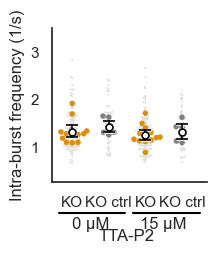

                       mean  ci_lower  ci_upper
genotype_3 parameter                           
KO_1       freq       1.307     1.196     1.444
KO_2       freq       1.239     1.136     1.351
KO_ctrl_1  freq       1.410     1.291     1.533
KO_ctrl_2  freq       1.307     1.162     1.459


C:\Users\dinhha\AppData\Local\Temp\ipykernel_6084\185011531.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df.groupby([group]).mean()[v]


In [17]:
data_subset = data[(data["pos"]==2)&
                (data["count"]>5)].dropna(subset=["rel_intraburst_freq"])
# data_subset_2 are cells from data_subset at pos 1
data_subset_2 = data_subset[["cell", "recording","freq_pos1", "genotype_2" ]].rename(columns={"freq_pos1": "freq"})
data_subset_2["pos"] = 1
#reshape data_subset to data_subset_3
data_subset_3 = data_subset[["cell", "recording","intraburst_freq", "genotype_2"]].rename(columns={"intraburst_freq": "freq"})
data_subset_3["pos"] = 2
#concat data
data_subset_4 = pd.concat((data_subset_2, data_subset_3)).reset_index(drop=True)
data_subset_4 = data_subset_4[(data_subset_4["genotype_2"]=="KO") | (data_subset_4["genotype_2"]== "KO_ctrl")]
data_subset_4["genotype_3"] = data_subset_4["genotype_2"]+"_"+(data_subset_4["pos"]).astype(str)
df_4 = data_subset_4.groupby(["genotype_3", "recording", "pos"]).mean().reset_index()



fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype_3", y="freq", data=df_4, 
               order= ["KO_1", "KO_ctrl_1", "KO_2", "KO_ctrl_2"],
                palette=[color_palette[1], "grey"],
                 s=4,
                zorder=2)

g = sns.swarmplot(x="genotype_3", y="freq", data=data_subset_4, 
               order= ["KO_1", "KO_ctrl_1", "KO_2", "KO_ctrl_2"],
                  size=1.2,
                  zorder=1,  palette=["lightgrey", "lightgrey"])




##### plot white markers
sns.lineplot(x="genotype_3", y="freq",
             data=df_4,
             lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

#plot black markers
sns.lineplot(x="genotype_3", y="freq", 
             data=df_4,
            lw=0,
            errorbar=("ci",95),
            n_boot=n_boot, seed=seed,
            zorder=10,  
            err_style="bars",
            err_kws=error_style,
            fillstyle="full", 
            **filled_marker_style)



plt.legend([],[], frameon=False)


g.set_ylabel("Intra-burst frequency (1/s)")
g.set_xlabel("") 
g.set_xticklabels(["KO", "KO ctrl", "KO", "KO ctrl"])
#g.set_xlabel("TTA-P2")



trans = g.get_xaxis_transform()
g.annotate('0 µM', xy=(0.5, -0.22), xycoords=trans, ha="center", va="top")
g.plot([-0.35,1.45],[-.2,-.2], color="k", transform=trans, clip_on=False)

g.annotate('15 µM', xy=(2.5, -0.22), xycoords=trans, ha="center", va="top")
g.plot([1.65,3.5],[-.2,-.2], color="k", transform=trans, clip_on=False)

g.annotate('TTA-P2', xy=(1.5, -0.3), xycoords=trans, ha="center", va="top")


plt.ylim(0.25, 3.5)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.show()


print(calculate_ci(df_4, ["freq"], "genotype_3"))
